In [27]:
#Check para ver si lee mi key

import os
from dotenv import load_dotenv
import requests
import pandas as pd
from io import StringIO
import time

# 1) Cargar el archivo .env
load_dotenv()

# 2) Leer la variable del entorno
API_KEY = os.getenv("AEMET_API_KEY")

# 3) Comprobar que se ha cargado
if API_KEY is None:
    print("No se ha encontrado AEMET_API_KEY. Revisa tu archivo .env")
else:
    print("✅ API key cargada correctamente. Longitud:", len(API_KEY))
    # Opcional: mostrar solo los primeros caracteres para comprobar
    print("Inicio de la key:", API_KEY[:10], "... (oculto)")



✅ API key cargada correctamente. Longitud: 292
Inicio de la key: eyJhbGciOi ... (oculto)


In [28]:
# Estación de Peñafiel (código que ves en la web: 2166Y)
STATION_ID = "2166Y"

# Endpoint /api/ de climatologías mensuales/anuales:
BASE_URL = (
    "https://opendata.aemet.es/opendata/api/"
    "valores/climatologicos/mensualesanuales/datos/"
    "anioini/{year}/aniofin/{year}/estacion/{station}"
)

print("✅ Configuración lista para estación", STATION_ID)


✅ Configuración lista para estación 2166Y


In [29]:
# evitar errores de tiempos de espera

def get_with_retry(url, *, headers=None, params=None, max_retries=5, base_wait=5, label=""):
    """
    Hace una petición GET con reintentos si recibe 429 Too Many Requests.
    - max_retries: nº máximo de intentos.
    - base_wait: segundos base de espera (se multiplica por el nº de intento).
    """
    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.get(url, headers=headers, params=params, timeout=30)
        except Exception as e:
            print(f"[{label}] ❌ Error en intento {attempt}: {e}")
            # si es un error de conexión raro, esperamos un poco y reintentamos
            time.sleep(base_wait * attempt)
            continue

        # Si es 429 Too Many Requests → esperamos y reintentamos
        if resp.status_code == 429:
            wait = base_wait * attempt
            print(f"[{label}] ⚠️ 429 Too Many Requests. Esperando {wait} segundos antes de reintentar...")
            time.sleep(wait)
            continue

        # Para cualquier otro código, si es error >400 lanza excepción:
        try:
            resp.raise_for_status()
            return resp  # éxito
        except requests.exceptions.HTTPError as e:
            print(f"[{label}] ❌ HTTPError (código {resp.status_code}): {e}")
            return None

    print(f"[{label}] ❌ Se alcanzó el nº máximo de reintentos ({max_retries})")
    return None


In [30]:
# Crea función para descargar datos ajustado con control de errores

def get_aemet_year(year):
    """
    Descarga climatologías mensuales/anuales de AEMET para un año y la estación 2166Y.
    Usa la API con reintentos automáticos si recibe 429 Too Many Requests.
    """

    # 1. Construir la URL del endpoint API
    url_api = BASE_URL.format(year=year, station=STATION_ID)

    # 2. Llamar al endpoint /api/... con tu key (con reintentos)
    headers = {"api_key": API_KEY}
    resp = get_with_retry(
        url_api,
        headers=headers,
        params=None,
        max_retries=5,
        base_wait=5,  # puedes bajar o subir esto
        label=f"API {year}"
    )

    if resp is None:
        print(f"[{year}] ❌ No se pudo obtener respuesta válida del endpoint API.")
        return pd.DataFrame()

    info = resp.json()
    estado = info.get("estado")
    desc = info.get("descripcion")

    if estado != 200:
        print(f"[{year}] ❌ Error de API: estado={estado}, descripcion={desc}")
        return pd.DataFrame()

    data_url = info["datos"]  # URL sh/... fresca

    # 3. Descargar los datos desde 'datos' (también con reintentos)
    r_data = get_with_retry(
        data_url,
        headers=None,
        params=None,
        max_retries=5,
        base_wait=5,
        label=f"DATOS {year}"
    )

    if r_data is None:
        print(f"[{year}] ❌ No se pudo descargar la URL de datos.")
        return pd.DataFrame()

    # 4. Intentar primero JSON (detecta 'datos expirados' o datos en JSON)
    try:
        data_json = r_data.json()

        # Caso dict con estado=404 → datos expirados
        if isinstance(data_json, dict) and data_json.get("estado") == 404:
            print(f"[{year}] ⚠️ 'datos expirados' en la URL de datos. Prueba en otro momento.")
            return pd.DataFrame()

        # Caso lista de dicts → datos en JSON
        if isinstance(data_json, list):
            df = pd.DataFrame(data_json)
            df["year"] = year
            print(f"[{year}] ✅ OK JSON con {len(df)} filas")
            return df

    except ValueError:
        # No era JSON → intentamos CSV
        pass

    # 5. Intentar CSV
    try:
        csv_buf = StringIO(r_data.text)
        df = pd.read_csv(csv_buf, sep=";")
        df["year"] = year
        print(f"[{year}] ✅ OK CSV con {len(df)} filas")
        return df
    except Exception as e:
        print(f"[{year}] ❌ Error leyendo CSV: {e}")
        return pd.DataFrame()


In [31]:
# Creamos bucle
# De 2003 a 2024 inclusive
years = list(range(2003, 2025))
dfs = []

for y in years:
    df_y = get_aemet_year(y)
    if not df_y.empty:
        dfs.append(df_y)
    else:
        print(f"[{y}] ⚠️ Sin datos válidos, no se añade al total.")

    # Pausa pequeña entre años para no saturar la API
    time.sleep(5)

if dfs:
    df_aemet = pd.concat(dfs, ignore_index=True, sort=False)
    print(f"\n✅ Concatenación completa: {len(df_aemet)} filas en total.")
else:
    df_aemet = pd.DataFrame()
    print("❌ No se han obtenido datos para ningún año.")

df_aemet.head()



[2003] ✅ OK JSON con 13 filas
[2004] ✅ OK JSON con 13 filas
[2005] ✅ OK JSON con 13 filas
[2006] ✅ OK JSON con 13 filas
[API 2007] ⚠️ 429 Too Many Requests. Esperando 5 segundos antes de reintentar...
[API 2007] ⚠️ 429 Too Many Requests. Esperando 10 segundos antes de reintentar...
[2007] ✅ OK JSON con 13 filas
[2008] ✅ OK JSON con 13 filas
[2009] ✅ OK JSON con 13 filas
[2010] ✅ OK JSON con 13 filas
[2011] ✅ OK JSON con 13 filas
[2012] ✅ OK JSON con 13 filas
[2013] ✅ OK JSON con 13 filas
[2014] ✅ OK JSON con 13 filas
[2015] ✅ OK JSON con 13 filas
[API 2016] ⚠️ 429 Too Many Requests. Esperando 5 segundos antes de reintentar...
[2016] ✅ OK JSON con 13 filas
[2017] ✅ OK JSON con 13 filas
[2018] ✅ OK JSON con 13 filas
[2019] ✅ OK JSON con 13 filas
[2020] ✅ OK JSON con 13 filas
[2021] ✅ OK JSON con 13 filas
[2022] ✅ OK JSON con 13 filas
[2023] ✅ OK JSON con 13 filas
[2024] ✅ OK JSON con 13 filas

✅ Concatenación completa: 286 filas en total.


,indicativo,p_max,np_100,np_001,np_300,p_mes,np_010,fecha,tm_min,ta_max,ts_min,nt_30,ta_min,nt_00,ti_max,tm_mes,tm_max,year,e,hr,n_cub,n_des,n_nub
0,2166Y,22.8(30),5,19,0,121.2,15,2003-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
1,2166Y,11.6(23),1,15,0,48.8,8,2003-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
2,2166Y,5.6(29),0,15,0,26.2,5,2003-12,0.4,16.2(21),6.0,0,-3.7(17),16,3.0,4.7,8.9,2003,NaN,NaN,NaN,NaN,NaN
3,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
4,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN


In [32]:
# Exportar a CSV
df_aemet.to_csv("aemet_vino_raw.csv", index=False)

In [33]:
#Mostrar todas las columnas del dataframe
pd.set_option('display.max_columns', None)
print(df_aemet.columns)

Index(['indicativo', 'p_max', 'np_100', 'np_001', 'np_300', 'p_mes', 'np_010',
       'fecha', 'tm_min', 'ta_max', 'ts_min', 'nt_30', 'ta_min', 'nt_00',
       'ti_max', 'tm_mes', 'tm_max', 'year', 'e', 'hr', 'n_cub', 'n_des',
       'n_nub'],
      dtype='object')


In [34]:
# copy para no perder columnas originales
df_aemet_clean = df_aemet.copy()


In [35]:
# Data cleaning: nos quedamos con las columnas que nos interesan y las renombramos
# columnas de interés: indicativo, fecha, p_mes, nt_30, nt_00, tm_mes, year, hr
df_aemet_clean = df_aemet.rename(columns={"indicativo": "estacion", "fecha": "fecha_mes", "p_mes": "precipitacion_total_mensual", 
                          "nt_30": "num_dias_temp_mayor30", "nt_00": "num_dias_temp_menor0", 
                          "tm_mes": "temp_media_mes", "year": "año", "hr": "humedad_relativa"})
df_aemet_clean.head()


,estacion,p_max,np_100,np_001,np_300,precipitacion_total_mensual,np_010,fecha_mes,tm_min,ta_max,ts_min,num_dias_temp_mayor30,ta_min,num_dias_temp_menor0,ti_max,temp_media_mes,tm_max,año,e,humedad_relativa,n_cub,n_des,n_nub
0,2166Y,22.8(30),5,19,0,121.2,15,2003-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
1,2166Y,11.6(23),1,15,0,48.8,8,2003-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
2,2166Y,5.6(29),0,15,0,26.2,5,2003-12,0.4,16.2(21),6.0,0,-3.7(17),16,3.0,4.7,8.9,2003,NaN,NaN,NaN,NaN,NaN
3,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
4,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN


In [36]:
#check datos columnas
df_aemet_clean.dtypes

estacion                       object
p_max                          object
np_100                         object
np_001                         object
np_300                         object
precipitacion_total_mensual    object
np_010                         object
fecha_mes                      object
tm_min                         object
ta_max                         object
ts_min                         object
num_dias_temp_mayor30          object
ta_min                         object
num_dias_temp_menor0           object
ti_max                         object
temp_media_mes                 object
tm_max                         object
año                             int64
e                              object
humedad_relativa               object
n_cub                          object
n_des                          object
n_nub                          object
dtype: object

In [37]:
# Cambiar todo el dataframe a float excepto las columnas de fecha_mes, año y estacion (excepto tambien las que tienen paréntesis)
cols_to_float = [col for col in df_aemet_clean.columns if col not in ['fecha_mes', 'año', 'estacion', 'p_max', 'ta_max', 'ta_min']]
df_aemet_clean[cols_to_float] = df_aemet_clean[cols_to_float].astype(float)
df_aemet_clean.dtypes



estacion                        object
p_max                           object
np_100                         float64
np_001                         float64
np_300                         float64
precipitacion_total_mensual    float64
np_010                         float64
fecha_mes                       object
tm_min                         float64
ta_max                          object
ts_min                         float64
num_dias_temp_mayor30          float64
ta_min                          object
num_dias_temp_menor0           float64
ti_max                         float64
temp_media_mes                 float64
tm_max                         float64
año                              int64
e                              float64
humedad_relativa               float64
n_cub                          float64
n_des                          float64
n_nub                          float64
dtype: object

In [38]:
df_aemet_clean.columns.tolist()

['estacion',
 'p_max',
 'np_100',
 'np_001',
 'np_300',
 'precipitacion_total_mensual',
 'np_010',
 'fecha_mes',
 'tm_min',
 'ta_max',
 'ts_min',
 'num_dias_temp_mayor30',
 'ta_min',
 'num_dias_temp_menor0',
 'ti_max',
 'temp_media_mes',
 'tm_max',
 'año',
 'e',
 'humedad_relativa',
 'n_cub',
 'n_des',
 'n_nub']

In [39]:
# Crear una nueva columna para calcular la humedad de una forma manual -> tm_min/tm_max * 100 - asegurándonos de que ambas columnas son numéricas 
df_aemet_clean["humedad_relativa_manual"] = (
    df_aemet_clean["tm_min"] / df_aemet_clean["tm_max"] * 100
)

df_aemet_clean.head(20)


,estacion,p_max,np_100,np_001,np_300,precipitacion_total_mensual,np_010,fecha_mes,tm_min,ta_max,ts_min,num_dias_temp_mayor30,ta_min,num_dias_temp_menor0,ti_max,temp_media_mes,tm_max,año,e,humedad_relativa,n_cub,n_des,n_nub,humedad_relativa_manual
0,2166Y,22.8(30),5.0,19.0,0.0,121.2,15.0,2003-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
1,2166Y,11.6(23),1.0,15.0,0.0,48.8,8.0,2003-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
2,2166Y,5.6(29),0.0,15.0,0.0,26.2,5.0,2003-12,0.4,16.2(21),6.0,0.0,-3.7(17),16.0,3.0,4.7,8.9,2003,NaN,NaN,NaN,NaN,NaN,4.494382
3,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
4,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
5,2166Y,10.4(18),2.0,13.0,0.0,42.6,8.0,2003-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
6,2166Y,14.8(22),1.0,10.0,0.0,29.0,5.0,2003-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
7,2166Y,15.0(19),1.0,10.0,0.0,38.2,8.0,2003-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
8,2166Y,6.8(31),0.0,7.0,0.0,26.2,6.0,2003-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
9,2166Y,6.4(12),0.0,9.0,0.0,19.4,8.0,2003-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_aemet_clean.columns.tolist()

['estacion',
 'p_max',
 'np_100',
 'np_001',
 'np_300',
 'precipitacion_total_mensual',
 'np_010',
 'fecha_mes',
 'tm_min',
 'ta_max',
 'ts_min',
 'num_dias_temp_mayor30',
 'ta_min',
 'num_dias_temp_menor0',
 'ti_max',
 'temp_media_mes',
 'tm_max',
 'año',
 'e',
 'humedad_relativa',
 'n_cub',
 'n_des',
 'n_nub',
 'humedad_relativa_manual']

In [41]:
#Eliminar columnas innecesarias, por ejemplo np_100
df_aemet_clean.drop(columns=['np_100', 'np_001', 'np_300', 'np_010', 'tm_min', 'ta_max', 'ts_min', 'ta_min', 'ti_max', 'tm_max', 'e', 'n_cub', 'n_des', 'n_nub', 'p_max'], inplace=True)
df_aemet_clean.head()

,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual
0,2166Y,121.2,2003-10,NaN,NaN,NaN,2003,NaN,NaN
1,2166Y,48.8,2003-11,NaN,NaN,NaN,2003,NaN,NaN
2,2166Y,26.2,2003-12,0.0,16.0,4.7,2003,NaN,4.494382
3,2166Y,NaN,2003-13,NaN,NaN,NaN,2003,NaN,NaN
4,2166Y,NaN,2003-1,NaN,NaN,NaN,2003,NaN,NaN


In [42]:
#Data cleanining de la columna de "fecha_mes" para tener mes y año (no días),
#por ejemplo tengo el formato "2003-1" quiero que sea 2003 en una columna y en otra columna lo que está después del "-", es decir, 1
# Separar en dos columnas: año y mes
df_aemet_clean[["año", "mes"]] = (
    df_aemet_clean["fecha_mes"]
        .astype(str)                # por si viene como número
        .str.split("-", expand=True)
        .astype(int)                # si quieres que sean enteros
)

df_aemet_clean.head()



,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual,mes
0,2166Y,121.2,2003-10,NaN,NaN,NaN,2003,NaN,NaN,10
1,2166Y,48.8,2003-11,NaN,NaN,NaN,2003,NaN,NaN,11
2,2166Y,26.2,2003-12,0.0,16.0,4.7,2003,NaN,4.494382,12
3,2166Y,NaN,2003-13,NaN,NaN,NaN,2003,NaN,NaN,13
4,2166Y,NaN,2003-1,NaN,NaN,NaN,2003,NaN,NaN,1


In [43]:
#Ordenar ascendentemente por año y mes:

df_aemet_clean = (
    df_aemet_clean
        .sort_values(["año", "mes"], ascending=[True, True])
        .reset_index(drop=True)
)

df_aemet_clean.head()

,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual,mes
0,2166Y,NaN,2003-1,NaN,NaN,NaN,2003,NaN,NaN,1
1,2166Y,42.6,2003-2,NaN,NaN,NaN,2003,NaN,NaN,2
2,2166Y,29.0,2003-3,NaN,NaN,NaN,2003,NaN,NaN,3
3,2166Y,38.2,2003-4,NaN,NaN,NaN,2003,NaN,NaN,4
4,2166Y,26.2,2003-5,NaN,NaN,NaN,2003,NaN,NaN,5


In [44]:
# Exportar a excel - check 2
df_aemet_clean.to_excel("aemet_vino_clean.xlsx", index=False)


In [45]:
#Crear una columna que calcule la media de la precipitación_total_mensual por año
df_aemet_clean["precipitacion_media_anual_ene_dic"] = (
    df_aemet_clean
        .groupby("año")["precipitacion_total_mensual"]
        .transform("mean")
)

In [46]:
# Nos quedamos con los meses del 4 al 9, ambos incluidos y eliminamos el resto y también eliminamos 2003 porque no tiene datos completos
df_aemet_clean = df_aemet_clean[
    (df_aemet_clean["mes"] >= 4) &  (df_aemet_clean["mes"] <= 9) &
    (df_aemet_clean["año"] != 2003)
]
df_aemet_clean.head(20)


,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual,mes,precipitacion_media_anual_ene_dic
16,2166Y,0.0,2004-4,0.0,4.0,9.2,2004,NaN,15.822785,4,8.700000
17,2166Y,0.2,2004-5,0.0,1.0,12.9,2004,NaN,33.160622,5,8.700000
18,2166Y,0.0,2004-6,12.0,0.0,20.3,2004,NaN,40.138408,6,8.700000
19,2166Y,0.0,2004-7,18.0,0.0,20.7,2004,NaN,39.393939,7,8.700000
20,2166Y,NaN,2004-8,NaN,NaN,NaN,2004,NaN,NaN,8,8.700000
21,2166Y,NaN,2004-9,3.0,0.0,18.1,2004,NaN,33.703704,9,8.700000
29,2166Y,35.4,2005-4,0.0,5.0,10.9,2005,NaN,22.346369,4,42.553846
30,2166Y,17.6,2005-5,4.0,0.0,15.5,2005,NaN,33.766234,5,42.553846
31,2166Y,29.2,2005-6,NaN,NaN,NaN,2005,NaN,NaN,6,42.553846
32,2166Y,3.4,2005-7,NaN,NaN,NaN,2005,NaN,NaN,7,42.553846


In [47]:
# Generar medias para todas mis variables (precipitacion_total_mensual, num_dias_temp_mayor30, num_dias_temp_menor0, temp_media_mes y humedad_relativa) por año
cols_media = [
    "precipitacion_total_mensual",
    "num_dias_temp_mayor30",
    "num_dias_temp_menor0",
    "temp_media_mes",
    "humedad_relativa",
    "humedad_relativa_manual",
]

# Aseguramos que esas columnas son numéricas (por si vienen como string)
df_aemet_clean[cols_media] = df_aemet_clean[cols_media].apply(
    pd.to_numeric, errors="coerce"
)

# Agrupamos por año y calculamos la media
df_aemet_mean = (
    df_aemet_clean
    .groupby("año")[cols_media]
    .mean()
    .reset_index()
)

#Añadir la columna de precipitacion_media_anual_ene_dic al df_aemet_mean
df_aemet_mean = df_aemet_mean.merge(
    df_aemet_clean[["año", "precipitacion_media_anual_ene_dic"]].drop_duplicates(),
    on="año",
    how="left"
)
df_aemet_mean.head(21)




,año,precipitacion_total_mensual,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,humedad_relativa,humedad_relativa_manual,precipitacion_media_anual_ene_dic
0,2004,0.050000,6.600000,1.000000,16.240000,NaN,32.443892,8.700000
1,2005,18.833333,2.000000,2.500000,13.200000,NaN,28.056301,42.553846
2,2006,27.200000,9.166667,1.000000,18.200000,NaN,37.337666,57.384615
3,2007,14.950000,4.000000,0.833333,16.316667,NaN,34.959299,21.175000
4,2008,60.750000,3.750000,0.250000,16.375000,NaN,39.639432,46.175000
5,2009,18.360000,8.000000,1.500000,17.283333,NaN,35.609556,26.911111
6,2010,37.680000,3.800000,2.000000,15.660000,56.000000,36.065573,43.418182
7,2011,15.700000,6.000000,0.000000,17.683333,54.666667,37.871439,36.507692
8,2012,29.466667,5.666667,0.166667,16.783333,60.000000,37.598473,45.661538
9,2013,21.016667,7.000000,1.333333,16.000000,62.333333,34.733125,62.630769


In [48]:
#exportar excel - check 3
df_aemet_mean.to_excel("aemet_vino_check3.xlsx", index=False)

In [49]:
# para datos Nan del 2004-2009 de humedad_relativa queremos darles los valores de humedad_relativa_manual y sumarles + 16
df_aemet_mean.loc[
    (df_aemet_mean["año"].between(2004, 2009)) & (df_aemet_mean["humedad_relativa"].isna()),
    "humedad_relativa"
] = df_aemet_mean["humedad_relativa_manual"] + 16   
df_aemet_mean.head(21)

,año,precipitacion_total_mensual,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,humedad_relativa,humedad_relativa_manual,precipitacion_media_anual_ene_dic
0,2004,0.050000,6.600000,1.000000,16.240000,48.443892,32.443892,8.700000
1,2005,18.833333,2.000000,2.500000,13.200000,44.056301,28.056301,42.553846
2,2006,27.200000,9.166667,1.000000,18.200000,53.337666,37.337666,57.384615
3,2007,14.950000,4.000000,0.833333,16.316667,50.959299,34.959299,21.175000
4,2008,60.750000,3.750000,0.250000,16.375000,55.639432,39.639432,46.175000
5,2009,18.360000,8.000000,1.500000,17.283333,51.609556,35.609556,26.911111
6,2010,37.680000,3.800000,2.000000,15.660000,56.000000,36.065573,43.418182
7,2011,15.700000,6.000000,0.000000,17.683333,54.666667,37.871439,36.507692
8,2012,29.466667,5.666667,0.166667,16.783333,60.000000,37.598473,45.661538
9,2013,21.016667,7.000000,1.333333,16.000000,62.333333,34.733125,62.630769


In [54]:
#Columnas finales del dataframe con medias teniendo en cuenta meses Abril a Septiembre:
df_aemet_mean.columns.tolist()
df_aemet_mean.head(21)

,año,precipitacion_total_mensual,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,humedad_relativa,humedad_relativa_manual,precipitacion_media_anual_ene_dic
0,2004,0.050000,6.600000,1.000000,16.240000,48.443892,32.443892,8.700000
1,2005,18.833333,2.000000,2.500000,13.200000,44.056301,28.056301,42.553846
2,2006,27.200000,9.166667,1.000000,18.200000,53.337666,37.337666,57.384615
3,2007,14.950000,4.000000,0.833333,16.316667,50.959299,34.959299,21.175000
4,2008,60.750000,3.750000,0.250000,16.375000,55.639432,39.639432,46.175000
5,2009,18.360000,8.000000,1.500000,17.283333,51.609556,35.609556,26.911111
6,2010,37.680000,3.800000,2.000000,15.660000,56.000000,36.065573,43.418182
7,2011,15.700000,6.000000,0.000000,17.683333,54.666667,37.871439,36.507692
8,2012,29.466667,5.666667,0.166667,16.783333,60.000000,37.598473,45.661538
9,2013,21.016667,7.000000,1.333333,16.000000,62.333333,34.733125,62.630769


In [56]:
# Renombrar finalmente las columnas y redondeos de números decimales
df_aemet_mean = df_aemet_mean.rename(columns={
    "año": "año",
    "precipitacion_total_mensual": "precipitacion_total_mensual(mm)",
    "num_dias_temp_mayor30": "num_dias_temp_mayor30(c)",
    "num_dias_temp_menor0": "num_dias_temp_menor0(c)",
    "temp_media_mes": "temp_media_mes(c)",
    "humedad_relativa": "humedad_relativa(%)",
    "precipitacion_media_anual_ene_dic": "precipitacion_media_anual_ene_dic(mm)"
})
df_aemet_mean.head(21)

#redondeos para todas las columnas menos año
cols_to_round = [
    "precipitacion_total_mensual(mm)",
    "num_dias_temp_mayor30(c)",
    "num_dias_temp_menor0(c)",
    "temp_media_mes(c)",
    "humedad_relativa(%)",
    "precipitacion_media_anual_ene_dic(mm)"
]

for col in cols_to_round:
    df_aemet_mean[col] = df_aemet_mean[col].round(2)

df_aemet_mean.head(21)

,año,precipitacion_total_mensual(mm),num_dias_temp_mayor30(c),num_dias_temp_menor0(c),temp_media_mes(c),humedad_relativa(%),humedad_relativa_manual,precipitacion_media_anual_ene_dic(mm)
0,2004,0.05,6.60,1.00,16.24,48.44,32.443892,8.70
1,2005,18.83,2.00,2.50,13.20,44.06,28.056301,42.55
2,2006,27.20,9.17,1.00,18.20,53.34,37.337666,57.38
3,2007,14.95,4.00,0.83,16.32,50.96,34.959299,21.18
4,2008,60.75,3.75,0.25,16.38,55.64,39.639432,46.18
5,2009,18.36,8.00,1.50,17.28,51.61,35.609556,26.91
6,2010,37.68,3.80,2.00,15.66,56.00,36.065573,43.42
7,2011,15.70,6.00,0.00,17.68,54.67,37.871439,36.51
8,2012,29.47,5.67,0.17,16.78,60.00,37.598473,45.66
9,2013,21.02,7.00,1.33,16.00,62.33,34.733125,62.63


In [57]:
# eliminar humedad_relativa_manual
df_aemet_mean.drop(columns=['humedad_relativa_manual'], inplace=True)
df_aemet_mean.head(21)

,año,precipitacion_total_mensual(mm),num_dias_temp_mayor30(c),num_dias_temp_menor0(c),temp_media_mes(c),humedad_relativa(%),precipitacion_media_anual_ene_dic(mm)
0,2004,0.05,6.60,1.00,16.24,48.44,8.70
1,2005,18.83,2.00,2.50,13.20,44.06,42.55
2,2006,27.20,9.17,1.00,18.20,53.34,57.38
3,2007,14.95,4.00,0.83,16.32,50.96,21.18
4,2008,60.75,3.75,0.25,16.38,55.64,46.18
5,2009,18.36,8.00,1.50,17.28,51.61,26.91
6,2010,37.68,3.80,2.00,15.66,56.00,43.42
7,2011,15.70,6.00,0.00,17.68,54.67,36.51
8,2012,29.47,5.67,0.17,16.78,60.00,45.66
9,2013,21.02,7.00,1.33,16.00,62.33,62.63


In [60]:
# Exportar a excel limpio
df_aemet_mean.to_excel("df_aemet_final.xlsx", index=False)

In [59]:
!pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 45.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 31.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ----------------------------------- ---- 6.3/7.0 MB 29.7 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 27.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


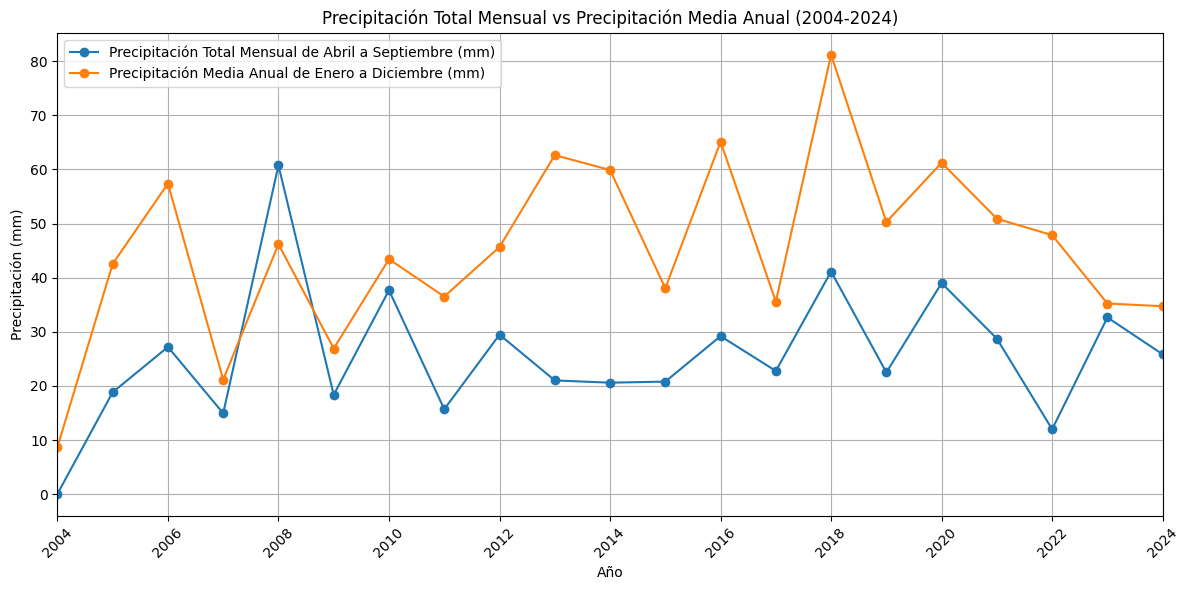

In [73]:
#Graficos para precipitaciones

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(12, 6))

plt.plot(
    df_aemet_mean["año"],
    df_aemet_mean["precipitacion_total_mensual(mm)"],
    marker='o',
    label='Precipitación Total Mensual de Abril a Septiembre (mm)'
)

plt.plot(
    df_aemet_mean["año"],
    df_aemet_mean["precipitacion_media_anual_ene_dic(mm)"],
    marker='o',
    label='Precipitación Media Anual de Enero a Diciembre (mm)'
)

plt.title('Precipitación Total Mensual vs Precipitación Media Anual (2004-2024)')
plt.xlabel('Año')
plt.ylabel('Precipitación (mm)')
plt.legend()
plt.grid()

# ---- Ajuste del eje X para mostrar TODOS los años ----
ax = plt.gca()

# Años únicos del DataFrame (por si acaso) ordenados
years = sorted(df_aemet_mean["año"].unique())

ax.set_xticks(years)                 # un tick por cada año
ax.set_xlim(min(years), max(years))  # límites del eje
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # asegura enteros

plt.xticks(rotation=45)  # opcional: girar etiquetas para que no se monten
plt.tight_layout()
plt.show()



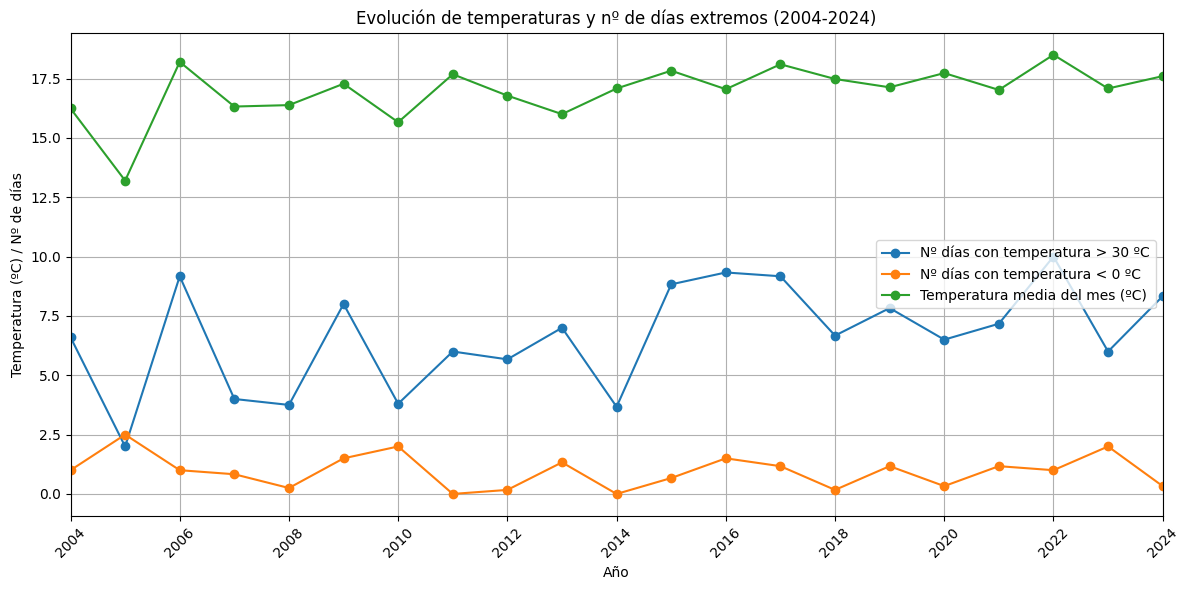

In [78]:
# Grafico sobre las temperaturas

plt.figure(figsize=(12, 6))

# Línea 1: nº días > 30ºC
plt.plot(
    df_aemet_mean["año"],
    df_aemet_mean["num_dias_temp_mayor30(c)"],
    marker="o",
    label="Nº días con temperatura > 30 ºC"
)

# Línea 2: nº días < 0ºC
plt.plot(
    df_aemet_mean["año"],
    df_aemet_mean["num_dias_temp_menor0(c)"],
    marker="o",
    label="Nº días con temperatura < 0 ºC"
)

# Línea 3: temperatura media del mes
plt.plot(
    df_aemet_mean["año"],
    df_aemet_mean["temp_media_mes(c)"],
    marker="o",
    label="Temperatura media del mes (ºC)"
)

plt.title("Evolución de temperaturas y nº de días extremos (2004-2024)")
plt.xlabel("Año")
plt.ylabel("Temperatura (ºC) / Nº de días")
plt.legend()
plt.grid()

# ---- Ajuste del eje X para mostrar TODOS los años ----
ax = plt.gca()

years = sorted(df_aemet_mean["año"].unique())  # años presentes en el DF
ax.set_xticks(years)                           # un tick por año
ax.set_xlim(min(years), max(years))           # límites del eje X
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # asegurar enteros

plt.xticks(rotation=45)  # opcional, para que no se monten
plt.tight_layout()
plt.show()





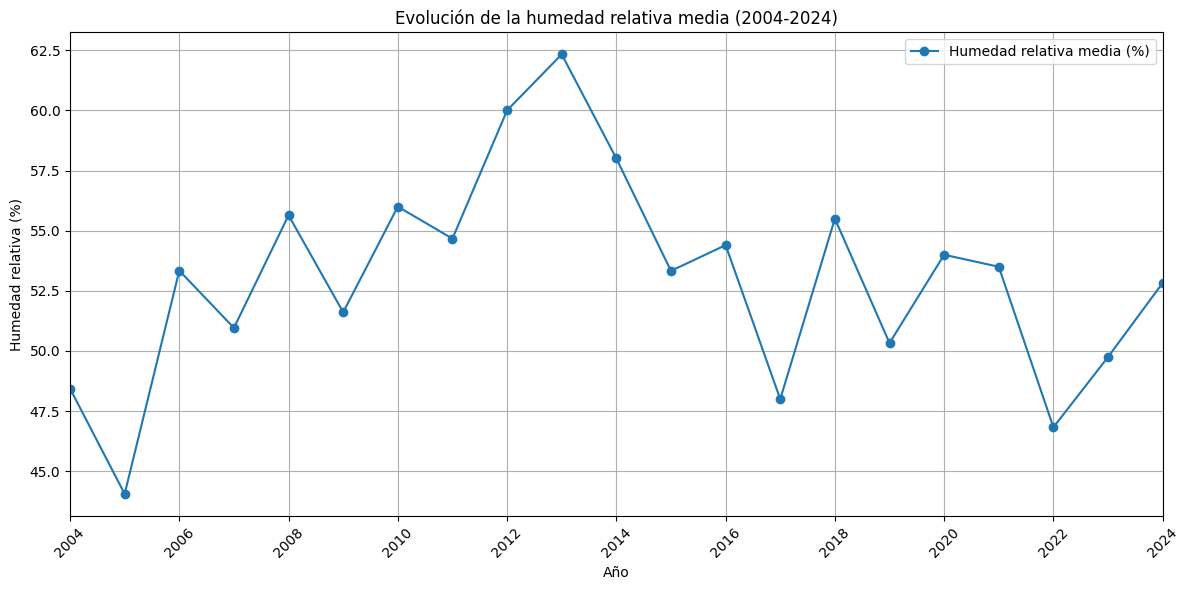

In [79]:
#Graficos relativos a la humedad relativa

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(12, 6))

# Línea de humedad relativa
plt.plot(
    df_aemet_mean["año"],
    df_aemet_mean["humedad_relativa(%)"],
    marker="o",
    label="Humedad relativa media (%)"
)

plt.title("Evolución de la humedad relativa media (2004-2024)")
plt.xlabel("Año")
plt.ylabel("Humedad relativa (%)")
plt.legend()
plt.grid()

# ---- Ajuste del eje X para mostrar TODOS los años ----
ax = plt.gca()

years = sorted(df_aemet_mean["año"].unique())   # años presentes en el DF
ax.set_xticks(years)                            # un tick por año
ax.set_xlim(min(years), max(years))             # límites del eje X
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # asegurar enteros

plt.xticks(rotation=45)  # opcional, por si las etiquetas se montan
plt.tight_layout()
plt.show()
